# Ashesi Student Success Prediction - Exploratory Data Analysis

This notebook provides comprehensive exploratory data analysis focused on **UNIQUE STUDENTS** (not data points).

## Research Questions
1. Predict first-year academic struggle from admissions data
2. Predict AJC cases from admissions data
3-6. Predict major success/failure using Year 1 and Year 1-2 data
7. Compare performance across math tracks
8. College algebra track success in CS major
9. Early prediction of extended graduation time

## Academic Policies
- **Probation**: CGPA < 2.0 at end of any regular semester
- **Dismissal**: Two consecutive semesters on probation without GPA ≥ 2.0
- **Dean's List**: Semester GPA ≥ 3.5

In [5]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Check if we are in the 'notebooks' directory and move up if so
if current_dir.endswith("notebooks"):
    os.chdir("..") # Move up one level to project root
    sys.path.append(os.getcwd()) # Add project root to python path

print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude


In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Project paths
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / 'data'
RESULTS_DIR = PROJECT_ROOT / 'results' / 'figures'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Directory: {DATA_DIR}")

Project Root: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude
Data Directory: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude/data


## 1. Data Loading (Unique Student Focus)

Load all datasets using the proper DataLoader that tracks unique students.

In [9]:
# Import custom loader
import sys
# sys.path.insert(0, str(PROJECT_ROOT))
from src.data.loader import DataLoader

# Initialize loader
loader = DataLoader(data_path=str(DATA_DIR))

# Load all datasets with unique student counts
print("="*60)
print("Loading Datasets (Showing UNIQUE STUDENTS, not just rows)")
print("="*60)
datasets = loader.load_all_datasets(verbose=True)

Loading Datasets (Showing UNIQUE STUDENTS, not just rows)
  ✓ Loaded application: 12,647 rows, 12,207 unique students
  ✓ Loaded cgpa: 24,648 rows, 3,718 unique students
  ✓ Loaded transcript: 115,421 rows, 3,684 unique students
  ✓ Loaded ajc: 143 rows, 134 unique students
  ✓ Loaded wassce: 1,274 rows, 1,264 unique students
  ✓ Loaded oa_level: 343 rows, 342 unique students
  ✓ Loaded hsdiploma: 51 rows, 51 unique students
  ✓ Loaded french: 23 rows, 23 unique students
  ✓ Loaded ib: 131 rows, 131 unique students
  ✓ Loaded other: 141 rows, 101 unique students


In [10]:
# Get unique student summary
print("\n" + "="*60)
print("UNIQUE STUDENT Summary Per Dataset")
print("="*60)
student_summary = loader.get_unique_student_summary()
display(student_summary)

# Total unique students across all datasets
all_students = loader.get_all_unique_students()
print(f"\nTotal UNIQUE STUDENTS across all datasets: {len(all_students):,}")


UNIQUE STUDENT Summary Per Dataset


,Dataset,Total Rows,Unique Students,Rows per Student
0,application,12647,12207,1.04
1,cgpa,24648,3718,6.63
2,transcript,115421,3684,31.33
3,ajc,143,134,1.07
4,wassce,1274,1264,1.01
5,oa_level,343,342,1.00
6,hsdiploma,51,51,1.00
7,french,23,23,1.00
8,ib,131,131,1.00
9,other,141,101,1.40



Total UNIQUE STUDENTS across all datasets: 13,746


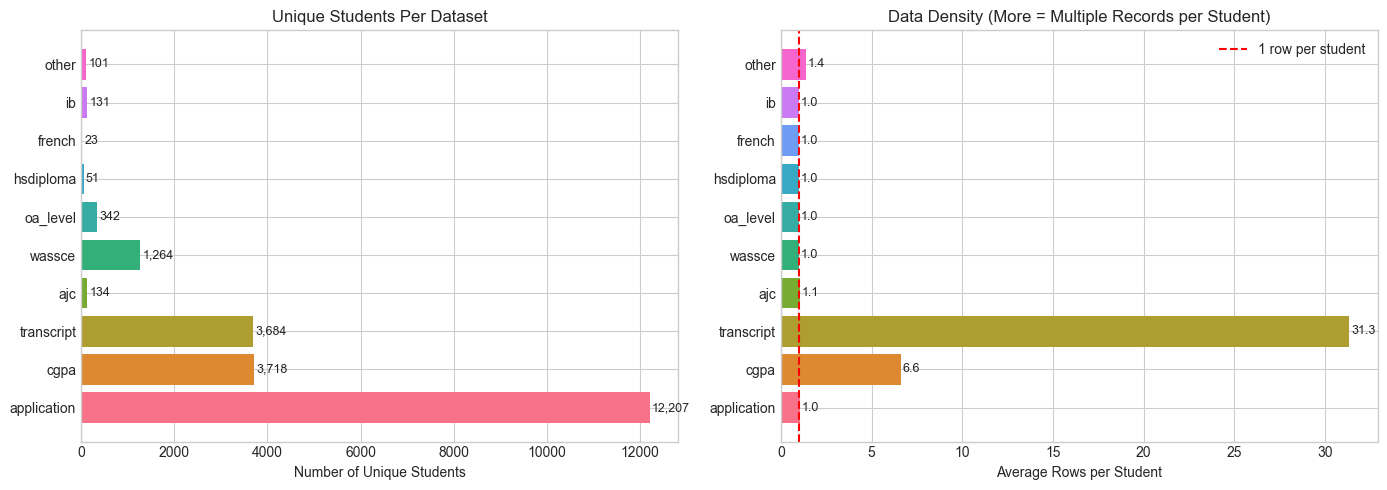


Key Insight: Transcript (~32 records/student) and CGPA (~7 records/student)
have multiple rows per student (one per semester), while HS exam data is 1:1.


In [11]:
# Visualize unique students vs rows per dataset
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Unique students per dataset
ax1 = axes[0]
colors = sns.color_palette('husl', len(student_summary))
bars = ax1.barh(student_summary['Dataset'], student_summary['Unique Students'], color=colors)
ax1.set_xlabel('Number of Unique Students')
ax1.set_title('Unique Students Per Dataset')
for bar, val in zip(bars, student_summary['Unique Students']):
    ax1.text(val + 50, bar.get_y() + bar.get_height()/2, f'{val:,}', va='center', fontsize=9)

# Rows per student (indicates repeated records)
ax2 = axes[1]
bars = ax2.barh(student_summary['Dataset'], student_summary['Rows per Student'], color=colors)
ax2.set_xlabel('Average Rows per Student')
ax2.set_title('Data Density (More = Multiple Records per Student)')
ax2.axvline(1.0, color='red', linestyle='--', label='1 row per student')
for bar, val in zip(bars, student_summary['Rows per Student']):
    ax2.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.1f}', va='center', fontsize=9)
ax2.legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'unique_students_per_dataset.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey Insight: Transcript (~32 records/student) and CGPA (~7 records/student)")
print("have multiple rows per student (one per semester), while HS exam data is 1:1.")

## 2. Create Master Student Table

Create a single table with **ONE ROW PER UNIQUE STUDENT** containing all relevant features.

In [12]:
# Create master table
print("="*60)
print("Creating Master Student Table")
print("="*60)
master = loader.create_master_student_table()

print(f"\n" + "="*60)
print(f"MASTER TABLE: {len(master):,} unique students, {len(master.columns)} features")
print("="*60)

Creating Master Student Table

  Creating master student table (one row per unique student)...
    Starting with 12,207 unique students from application data
    Merged HS exam data for 1,877 students
    Adding math track...
      From actual placement: 0 students
      Inferred from scores: 1,302 students
      Math track distribution:
math_track
Unknown            10905
Calculus            1078
Pre-Calculus         203
College Algebra       21
    Merged academic performance for 3,718 students
    Added Year 1 features for 3,234 students
    Merged AJC data: 134 students with cases
    ✓ Master table created: 12,207 unique students, 83 features

MASTER TABLE: 12,207 unique students, 83 features


In [13]:
# Show sample of master table
print("Sample of master data (key columns):")
key_cols = ['student_id', 'Gender', 'is_female', 'is_international', 'needs_financial_aid',
            'exam_source', 'math_track', 'hs_math_score', 'final_cgpa', 'y1_cgpa_end',
            'has_ajc_case', 'is_graduated', 'first_year_struggle', 'major_success']
display_cols = [c for c in key_cols if c in master.columns]
master[display_cols].head(10)

Sample of master data (key columns):


,student_id,Gender,is_female,is_international,needs_financial_aid,exam_source,math_track,hs_math_score,final_cgpa,y1_cgpa_end,has_ajc_case,is_graduated,first_year_struggle,major_success
0,Sd25fcbb18e84f890,M,0,0,1,NaN,Unknown,NaN,NaN,NaN,0,0,0,0
1,Sfd5f545f824e3b45,M,0,0,0,NaN,Unknown,NaN,NaN,NaN,0,0,0,0
2,Se4a2f9bcf28873f3,M,0,1,1,NaN,Unknown,NaN,NaN,NaN,0,0,0,0
3,S2c5748435b37f518,M,0,0,1,NaN,Unknown,NaN,NaN,NaN,0,0,0,0
4,Sa3d7b10c3d22ffe0,M,0,1,1,NaN,Unknown,NaN,NaN,NaN,0,0,0,0
5,Sba09afaf4389816d,M,0,1,1,NaN,Unknown,NaN,NaN,NaN,0,0,0,0
6,S6002000e73736198,F,1,1,1,NaN,Unknown,NaN,NaN,NaN,0,0,0,0
7,Sd759499b6390c8d7,M,0,0,0,NaN,Unknown,NaN,NaN,NaN,0,0,0,0
8,S5eadbf41162d7e5e,M,0,0,1,NaN,Unknown,NaN,NaN,NaN,0,0,0,0
9,Sf0cd5b5c7928acce,M,0,1,1,NaN,Unknown,NaN,NaN,NaN,0,0,0,0


## 3. Student Demographics Analysis

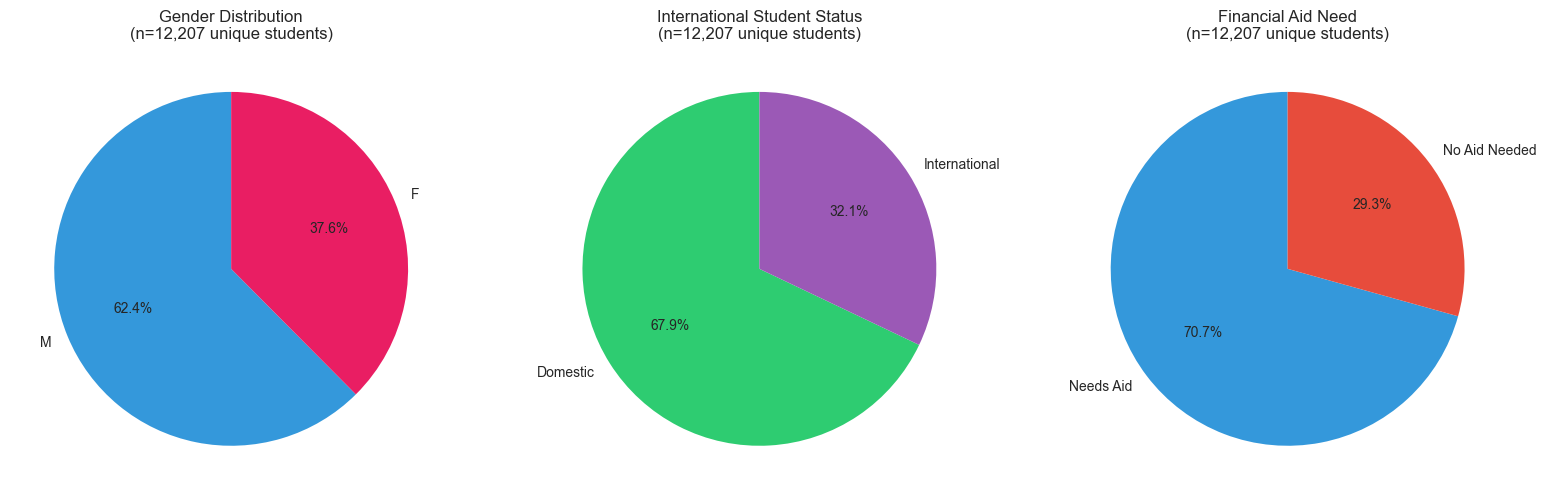

In [14]:
# Gender distribution (of unique students)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gender
ax1 = axes[0]
if 'Gender' in master.columns:
    gender_counts = master['Gender'].value_counts()
    ax1.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
            colors=['#3498db', '#e91e63'], startangle=90)
    ax1.set_title(f'Gender Distribution\n(n={len(master):,} unique students)')

# International status
ax2 = axes[1]
if 'is_international' in master.columns:
    intl_counts = master['is_international'].value_counts()
    labels = ['Domestic', 'International']
    ax2.pie(intl_counts.values, labels=[labels[i] for i in intl_counts.index],
            autopct='%1.1f%%', colors=['#2ecc71', '#9b59b6'], startangle=90)
    ax2.set_title(f'International Student Status\n(n={len(master):,} unique students)')

# Financial aid
ax3 = axes[2]
if 'needs_financial_aid' in master.columns:
    aid_counts = master['needs_financial_aid'].value_counts()
    labels = ['No Aid Needed', 'Needs Aid']
    ax3.pie(aid_counts.values, labels=[labels[i] for i in aid_counts.index],
            autopct='%1.1f%%', colors=['#3498db', '#e74c3c'], startangle=90)
    ax3.set_title(f'Financial Aid Need\n(n={len(master):,} unique students)')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'student_demographics.png', dpi=150, bbox_inches='tight')
plt.show()

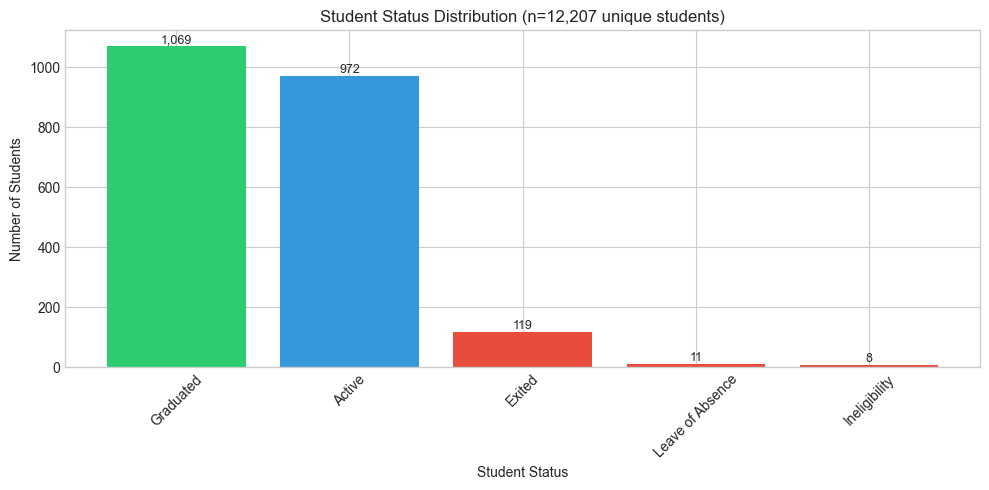

In [15]:
# Student status distribution
if 'student_status' in master.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    status_counts = master['student_status'].value_counts()
    colors = ['#2ecc71' if 'grad' in str(s).lower() else '#3498db' if 'active' in str(s).lower()
              else '#e74c3c' for s in status_counts.index]
    bars = ax.bar(status_counts.index.astype(str), status_counts.values, color=colors)
    ax.set_xlabel('Student Status')
    ax.set_ylabel('Number of Students')
    ax.set_title(f'Student Status Distribution (n={len(master):,} unique students)')
    ax.tick_params(axis='x', rotation=45)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}',
                ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'student_status_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

## 4. Math Track Analysis (Using Actual Placement Data)

**CRITICAL**: Math track is determined using actual placement columns from WASSCE data, not just inferred from scores.

Math Track Distribution (Unique Students)
math_track
Unknown            10905
Calculus            1078
Pre-Calculus         203
College Algebra       21
Name: count, dtype: int64

Total students with known math track: 1,302
Students with unknown track: 10,905


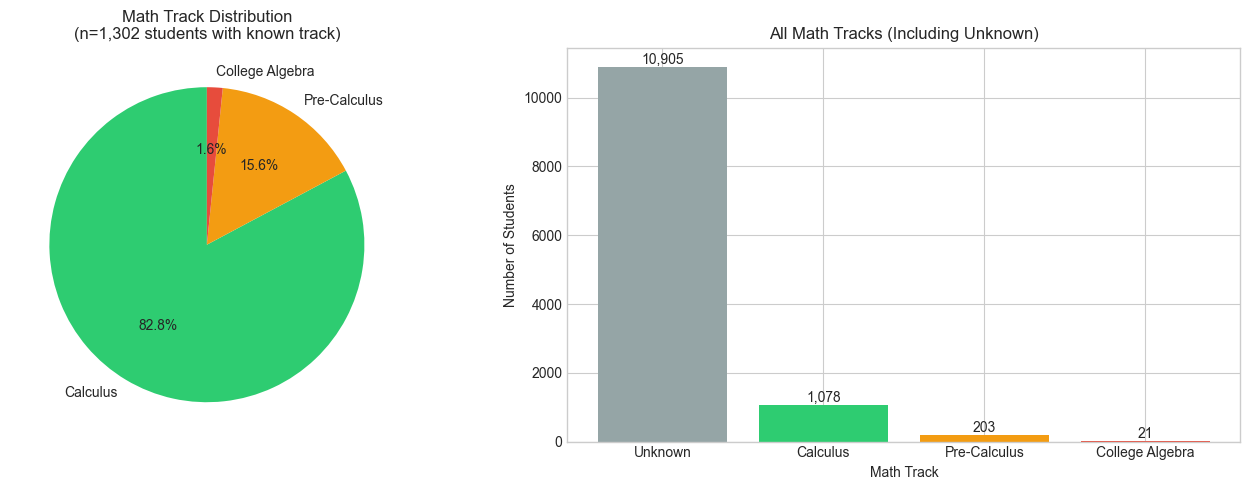

In [16]:
# Math track distribution
print("="*60)
print("Math Track Distribution (Unique Students)")
print("="*60)

if 'math_track' in master.columns:
    track_counts = master['math_track'].value_counts()
    print(track_counts)
    print(f"\nTotal students with known math track: {(master['math_track'] != 'Unknown').sum():,}")
    print(f"Students with unknown track: {(master['math_track'] == 'Unknown').sum():,}")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Pie chart
    ax1 = axes[0]
    known_tracks = track_counts[track_counts.index != 'Unknown']
    if len(known_tracks) > 0:
        colors = {'Calculus': '#2ecc71', 'Pre-Calculus': '#f39c12', 'College Algebra': '#e74c3c'}
        ax1.pie(known_tracks.values,
                labels=known_tracks.index,
                autopct='%1.1f%%',
                colors=[colors.get(t, '#95a5a6') for t in known_tracks.index],
                startangle=90)
        ax1.set_title(f'Math Track Distribution\n(n={known_tracks.sum():,} students with known track)')

    # Bar chart with all
    ax2 = axes[1]
    track_colors = [colors.get(t, '#95a5a6') for t in track_counts.index]
    bars = ax2.bar(track_counts.index, track_counts.values, color=track_colors)
    ax2.set_xlabel('Math Track')
    ax2.set_ylabel('Number of Students')
    ax2.set_title('All Math Tracks (Including Unknown)')
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}',
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'math_track_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

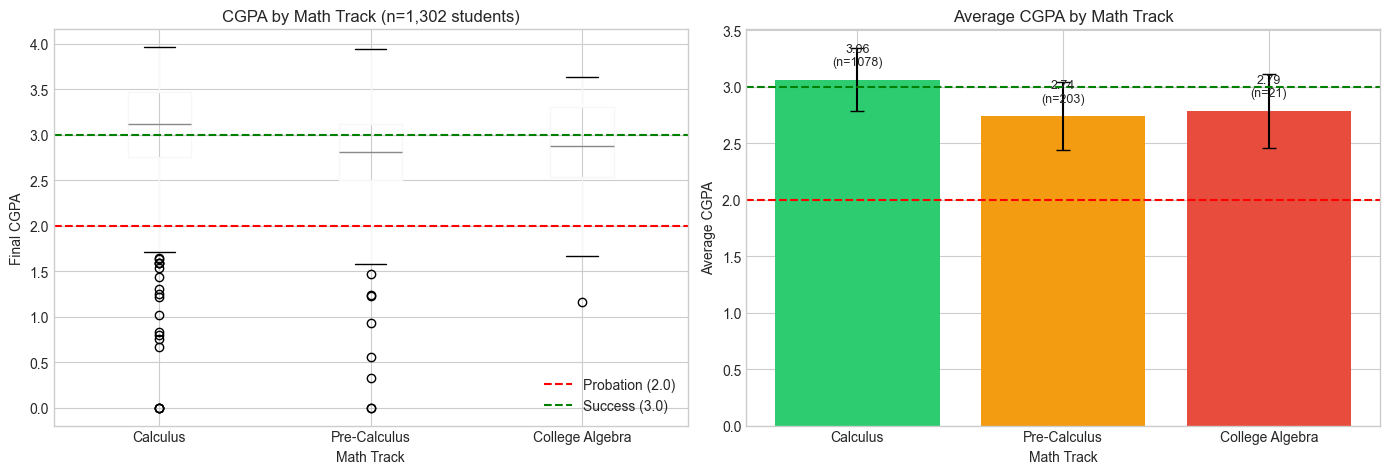

In [17]:
# Math track vs CGPA (RQ7)
if 'math_track' in master.columns and 'final_cgpa' in master.columns:
    known_track = master[master['math_track'] != 'Unknown'].copy()

    if len(known_track) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Box plot
        ax1 = axes[0]
        track_order = ['Calculus', 'Pre-Calculus', 'College Algebra']
        known_track['math_track'] = pd.Categorical(known_track['math_track'],
                                                    categories=track_order, ordered=True)
        known_track.boxplot(column='final_cgpa', by='math_track', ax=ax1)
        ax1.axhline(2.0, color='red', linestyle='--', linewidth=1.5, label='Probation (2.0)')
        ax1.axhline(3.0, color='green', linestyle='--', linewidth=1.5, label='Success (3.0)')
        ax1.set_xlabel('Math Track')
        ax1.set_ylabel('Final CGPA')
        ax1.set_title(f'CGPA by Math Track (n={len(known_track):,} students)')
        ax1.legend()
        plt.suptitle('')

        # Average CGPA by track
        ax2 = axes[1]
        track_avg = known_track.groupby('math_track')['final_cgpa'].agg(['mean', 'std', 'count'])
        track_avg = track_avg.reindex(track_order)
        colors = ['#2ecc71', '#f39c12', '#e74c3c']
        bars = ax2.bar(track_avg.index, track_avg['mean'], yerr=track_avg['std']/2,
                       color=colors, capsize=5)
        ax2.axhline(2.0, color='red', linestyle='--', linewidth=1.5)
        ax2.axhline(3.0, color='green', linestyle='--', linewidth=1.5)
        ax2.set_xlabel('Math Track')
        ax2.set_ylabel('Average CGPA')
        ax2.set_title('Average CGPA by Math Track')
        for bar, (idx, row) in zip(bars, track_avg.iterrows()):
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                     f'{row["mean"]:.2f}\n(n={int(row["count"])})',
                     ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'math_track_vs_cgpa.png', dpi=150, bbox_inches='tight')
        plt.show()

## 5. High School Exam Data Analysis

High School Exam Distribution (n=1,691 students with exam data):
exam_source
wassce       1124
oa_level      298
ib            120
other          94
hsdiploma      35
french         20
Name: count, dtype: int64


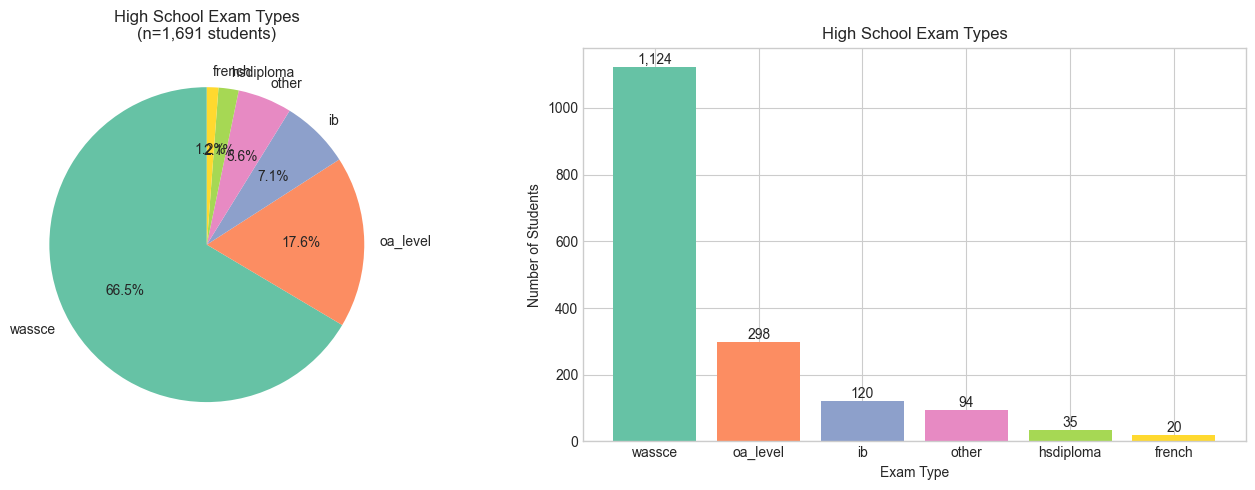

In [18]:
# Exam source distribution
if 'exam_source' in master.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    exam_counts = master['exam_source'].value_counts()
    print(f"High School Exam Distribution (n={exam_counts.sum():,} students with exam data):")
    print(exam_counts)

    # Pie chart
    ax1 = axes[0]
    ax1.pie(exam_counts.values, labels=exam_counts.index, autopct='%1.1f%%',
            colors=sns.color_palette('Set2', len(exam_counts)), startangle=90)
    ax1.set_title(f'High School Exam Types\n(n={exam_counts.sum():,} students)')

    # Bar chart
    ax2 = axes[1]
    bars = ax2.bar(exam_counts.index, exam_counts.values, color=sns.color_palette('Set2', len(exam_counts)))
    ax2.set_xlabel('Exam Type')
    ax2.set_ylabel('Number of Students')
    ax2.set_title('High School Exam Types')
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}',
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'hs_exam_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

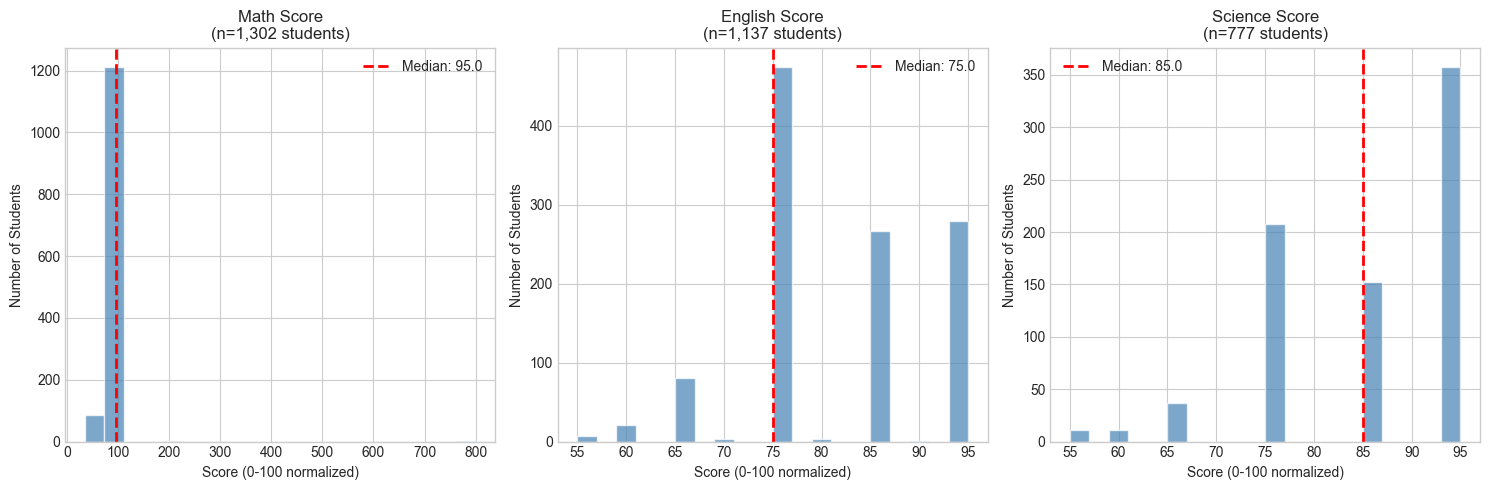

In [19]:
# High school score distributions
score_cols = ['hs_math_score', 'hs_english_score', 'hs_science_score']
available_scores = [c for c in score_cols if c in master.columns]

if available_scores:
    fig, axes = plt.subplots(1, len(available_scores), figsize=(5*len(available_scores), 5))
    if len(available_scores) == 1:
        axes = [axes]

    for ax, col in zip(axes, available_scores):
        valid_data = master[col].dropna()
        if len(valid_data) > 0:
            ax.hist(valid_data, bins=20, color='steelblue', edgecolor='white', alpha=0.7)
            ax.axvline(valid_data.median(), color='red', linestyle='--', linewidth=2,
                       label=f'Median: {valid_data.median():.1f}')
            ax.set_xlabel('Score (0-100 normalized)')
            ax.set_ylabel('Number of Students')
            ax.set_title(f'{col.replace("hs_", "").replace("_", " ").title()}\n(n={len(valid_data):,} students)')
            ax.legend()

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'hs_score_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()

## 6. Academic Performance Analysis (CGPA)

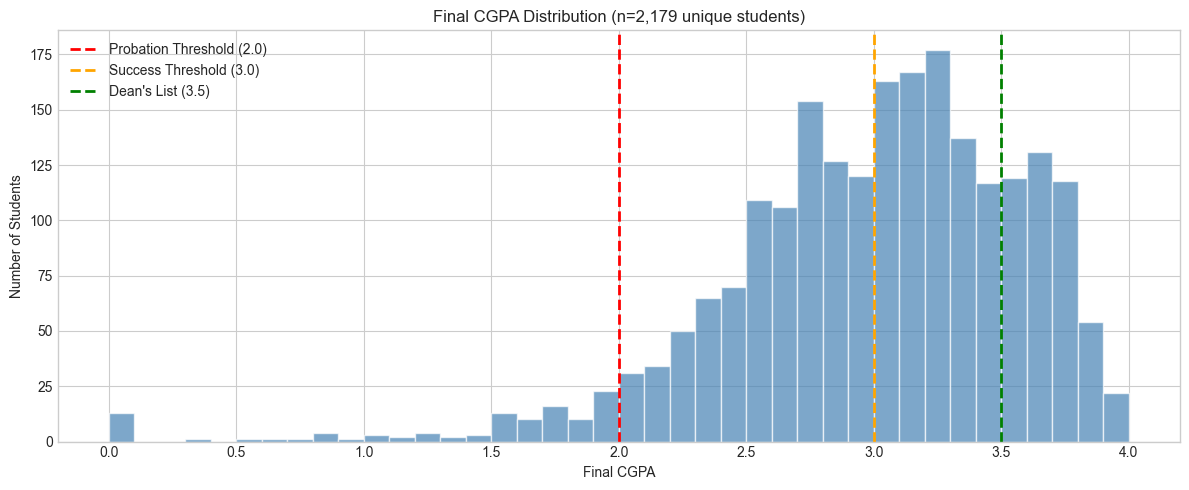


Final CGPA Statistics (n=2,179 students):
count    2179.000000
mean        2.991758
std         0.591636
min         0.000000
25%         2.670000
50%         3.060000
75%         3.410000
max         4.000000
Name: final_cgpa, dtype: float64


In [20]:
# CGPA distribution (unique students)
cgpa_cols = ['final_cgpa', 'avg_cgpa', 'min_cgpa', 'max_cgpa']
available_cgpa = [c for c in cgpa_cols if c in master.columns]

if available_cgpa:
    fig, ax = plt.subplots(figsize=(12, 5))

    if 'final_cgpa' in master.columns:
        valid_cgpa = master['final_cgpa'].dropna()
        ax.hist(valid_cgpa, bins=40, color='steelblue', edgecolor='white', alpha=0.7)
        ax.axvline(2.0, color='red', linestyle='--', linewidth=2, label='Probation Threshold (2.0)')
        ax.axvline(3.0, color='orange', linestyle='--', linewidth=2, label='Success Threshold (3.0)')
        ax.axvline(3.5, color='green', linestyle='--', linewidth=2, label="Dean's List (3.5)")
        ax.set_xlabel('Final CGPA')
        ax.set_ylabel('Number of Students')
        ax.set_title(f'Final CGPA Distribution (n={len(valid_cgpa):,} unique students)')
        ax.legend()

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'final_cgpa_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Statistics
    print(f"\nFinal CGPA Statistics (n={len(valid_cgpa):,} students):")
    print(valid_cgpa.describe())


Academic Standing (Unique Students)
Below 2.0 (Academic Danger): 108 (5.0%)
2.0-3.0 (Satisfactory): 866 (39.7%)
3.0-3.5 (Good): 761 (34.9%)
Above 3.5 (Excellent): 444 (20.4%)


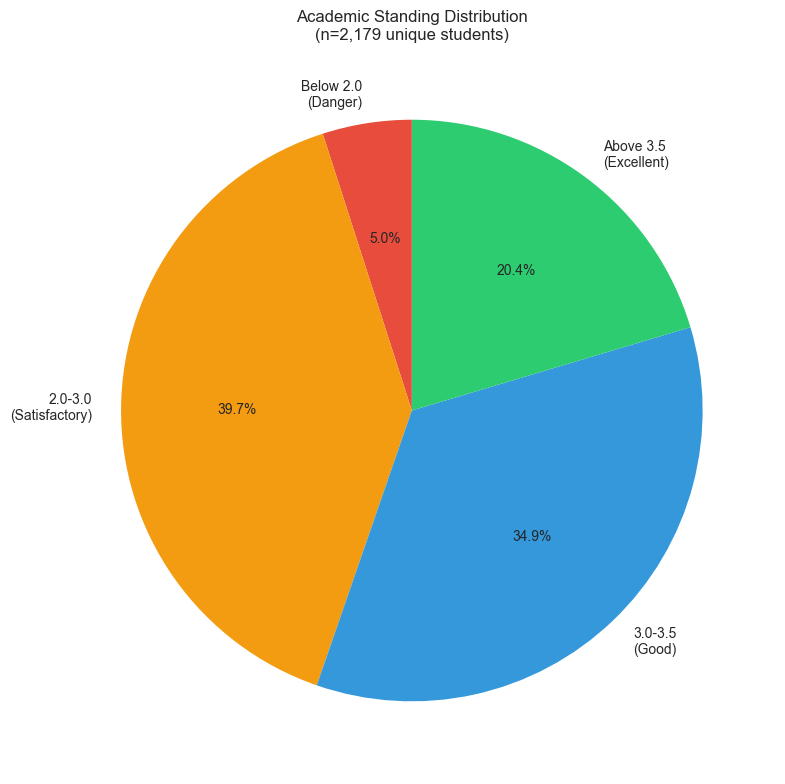

In [21]:
# Academic standing breakdown
print("\n" + "="*60)
print("Academic Standing (Unique Students)")
print("="*60)

if 'final_cgpa' in master.columns:
    valid = master[master['final_cgpa'].notna()]
    n_total = len(valid)

    below_2 = (valid['final_cgpa'] < 2.0).sum()
    between_2_3 = ((valid['final_cgpa'] >= 2.0) & (valid['final_cgpa'] < 3.0)).sum()
    between_3_35 = ((valid['final_cgpa'] >= 3.0) & (valid['final_cgpa'] < 3.5)).sum()
    above_35 = (valid['final_cgpa'] >= 3.5).sum()

    print(f"Below 2.0 (Academic Danger): {below_2:,} ({below_2/n_total*100:.1f}%)")
    print(f"2.0-3.0 (Satisfactory): {between_2_3:,} ({between_2_3/n_total*100:.1f}%)")
    print(f"3.0-3.5 (Good): {between_3_35:,} ({between_3_35/n_total*100:.1f}%)")
    print(f"Above 3.5 (Excellent): {above_35:,} ({above_35/n_total*100:.1f}%)")

    # Pie chart
    fig, ax = plt.subplots(figsize=(8, 8))
    labels = ['Below 2.0\n(Danger)', '2.0-3.0\n(Satisfactory)', '3.0-3.5\n(Good)', 'Above 3.5\n(Excellent)']
    sizes = [below_2, between_2_3, between_3_35, above_35]
    colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax.set_title(f'Academic Standing Distribution\n(n={n_total:,} unique students)')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'academic_standing_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

## 7. Target Variables Analysis (Class Imbalance)

In [22]:
# Target variables for our research questions
target_cols = {
    'first_year_struggle': 'RQ1: First Year Struggle (Y1 CGPA < 2.0)',
    'has_ajc_case': 'RQ2: Has AJC Case',
    'major_success': 'RQ3-6: Major Success (Graduated CGPA >= 3.0)',
    'extended_graduation': 'RQ9: Extended Graduation (> 8 semesters)',
    'ever_on_probation': 'Ever on Probation',
    'is_graduated': 'Graduated'
}

print("="*60)
print("Target Variable Distribution (Class Imbalance Analysis)")
print("="*60)

target_summary = []
for col, label in target_cols.items():
    if col in master.columns:
        valid = master[col].notna()
        n_total = valid.sum()
        n_positive = master[col].sum()
        pct_positive = n_positive / n_total * 100 if n_total > 0 else 0
        target_summary.append({
            'Target': label,
            'Total Students': n_total,
            'Positive Cases': n_positive,
            'Positive %': pct_positive
        })
        print(f"{label}:")
        print(f"  Total: {n_total:,}, Positive: {n_positive:,} ({pct_positive:.1f}%)")

target_df = pd.DataFrame(target_summary)

Target Variable Distribution (Class Imbalance Analysis)
RQ1: First Year Struggle (Y1 CGPA < 2.0):
  Total: 12,207, Positive: 142 (1.2%)
RQ2: Has AJC Case:
  Total: 12,207, Positive: 86 (0.7%)
RQ3-6: Major Success (Graduated CGPA >= 3.0):
  Total: 12,207, Positive: 685 (5.6%)
RQ9: Extended Graduation (> 8 semesters):
  Total: 12,207, Positive: 387 (3.2%)
Ever on Probation:
  Total: 12,207, Positive: 267 (2.2%)
Graduated:
  Total: 12,207, Positive: 1,069 (8.8%)


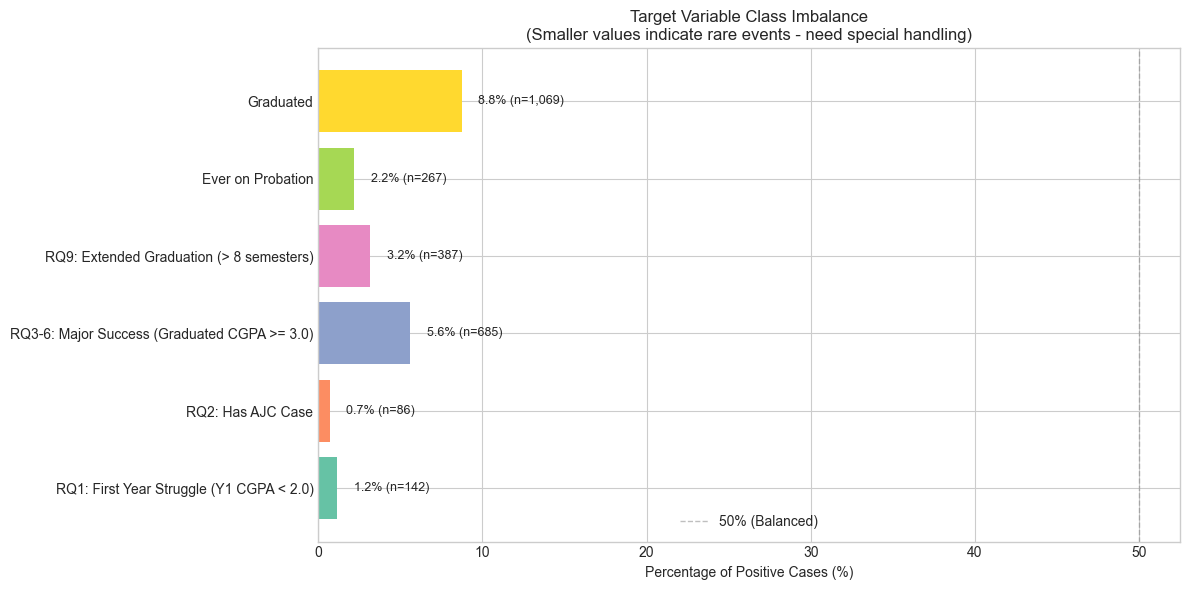


⚠️ CLASS IMBALANCE WARNING:
Targets with < 20% positive rate will need SMOTE/class weights during modeling.


In [23]:
# Visualize class imbalance
if len(target_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))

    bars = ax.barh(target_df['Target'], target_df['Positive %'],
                   color=sns.color_palette('Set2', len(target_df)))
    ax.axvline(50, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='50% (Balanced)')
    ax.set_xlabel('Percentage of Positive Cases (%)')
    ax.set_title('Target Variable Class Imbalance\n(Smaller values indicate rare events - need special handling)')

    for bar, (_, row) in zip(bars, target_df.iterrows()):
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{row["Positive %"]:.1f}% (n={int(row["Positive Cases"]):,})',
                va='center', fontsize=9)

    ax.legend()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'target_class_imbalance.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n⚠️ CLASS IMBALANCE WARNING:")
    print("Targets with < 20% positive rate will need SMOTE/class weights during modeling.")

## 8. AJC (Disciplinary) Analysis

AJC (Academic Judicial Committee) Analysis
Total AJC records: 143
Unique students with AJC cases: 134


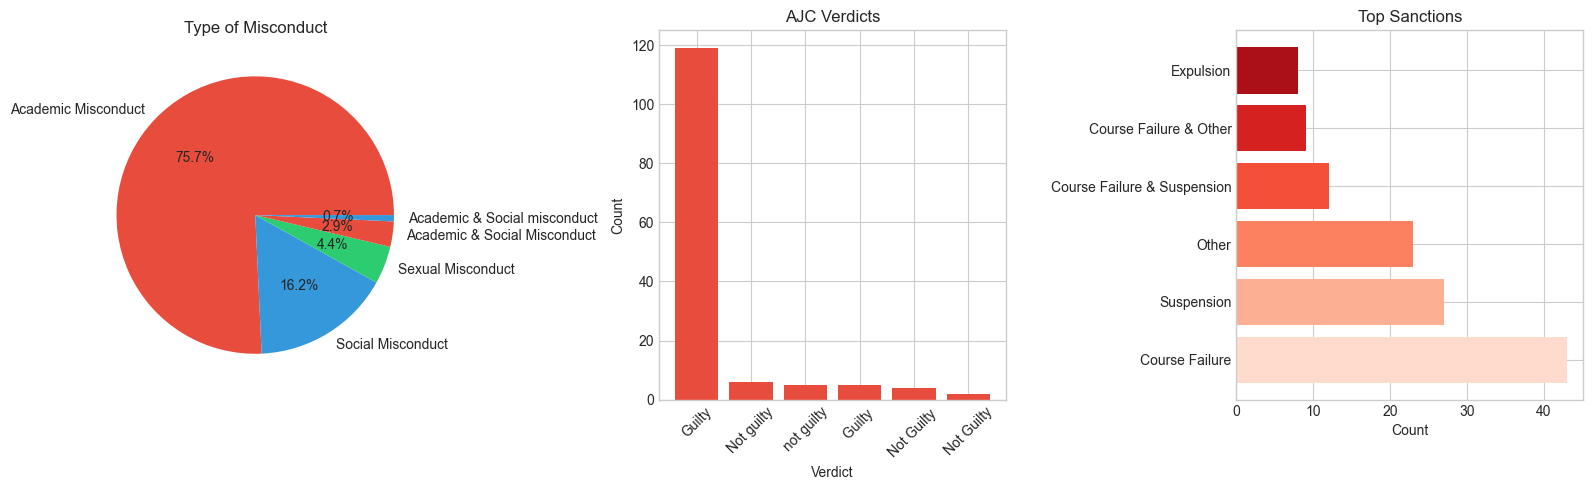

In [24]:
# AJC analysis
if 'ajc' in datasets:
    ajc = datasets['ajc']
    print("="*60)
    print("AJC (Academic Judicial Committee) Analysis")
    print("="*60)
    print(f"Total AJC records: {len(ajc):,}")
    print(f"Unique students with AJC cases: {ajc['student_id'].nunique():,}")

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # Misconduct type
    ax1 = axes[0]
    if 'Type of Misconduct' in ajc.columns:
        type_counts = ajc['Type of Misconduct'].value_counts()
        ax1.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%',
                colors=['#e74c3c', '#3498db', '#2ecc71'])
        ax1.set_title('Type of Misconduct')

    # Verdict
    ax2 = axes[1]
    if 'Verdict' in ajc.columns:
        verdict_counts = ajc['Verdict'].value_counts()
        colors = ['#e74c3c' if 'guilty' in str(v).lower() else '#2ecc71' for v in verdict_counts.index]
        ax2.bar(verdict_counts.index.astype(str), verdict_counts.values, color=colors)
        ax2.set_xlabel('Verdict')
        ax2.set_ylabel('Count')
        ax2.set_title('AJC Verdicts')
        ax2.tick_params(axis='x', rotation=45)

    # Sanction
    ax3 = axes[2]
    if 'Sanction' in ajc.columns:
        sanction_counts = ajc['Sanction'].value_counts().head(6)
        ax3.barh(sanction_counts.index.astype(str), sanction_counts.values,
                 color=sns.color_palette('Reds', len(sanction_counts)))
        ax3.set_xlabel('Count')
        ax3.set_title('Top Sanctions')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'ajc_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

## 9. Data Coverage Analysis (Student Overlap)

Student Data Coverage Across Datasets
Total unique students: 13,746


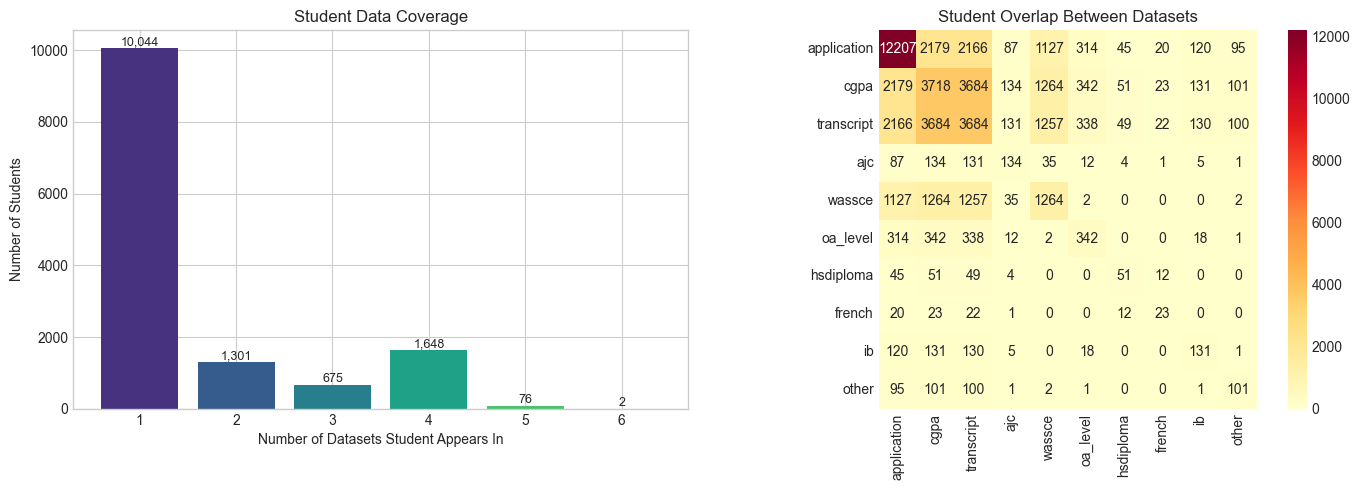

In [25]:
# Student data coverage across datasets
coverage = loader.get_student_data_coverage()

print("="*60)
print("Student Data Coverage Across Datasets")
print("="*60)
print(f"Total unique students: {len(coverage):,}")

# Distribution of dataset coverage per student
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
coverage_counts = coverage['datasets_count'].value_counts().sort_index()
bars = ax1.bar(coverage_counts.index, coverage_counts.values,
               color=sns.color_palette('viridis', len(coverage_counts)))
ax1.set_xlabel('Number of Datasets Student Appears In')
ax1.set_ylabel('Number of Students')
ax1.set_title('Student Data Coverage')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}',
             ha='center', va='bottom', fontsize=9)

# Dataset overlap heatmap
ax2 = axes[1]
data_cols = [col for col in coverage.columns if col.startswith('in_')]
overlap_matrix = pd.DataFrame(index=data_cols, columns=data_cols, dtype=int)
for col1 in data_cols:
    for col2 in data_cols:
        overlap_matrix.loc[col1, col2] = (coverage[col1] & coverage[col2]).sum()
overlap_matrix.index = [c.replace('in_', '') for c in overlap_matrix.index]
overlap_matrix.columns = [c.replace('in_', '') for c in overlap_matrix.columns]
sns.heatmap(overlap_matrix.astype(int), annot=True, fmt='d', cmap='YlOrRd', ax=ax2, square=True)
ax2.set_title('Student Overlap Between Datasets')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'student_data_coverage.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Missing Data Analysis

Missing Data Analysis (Master Student Table)
Columns with missing data: 49


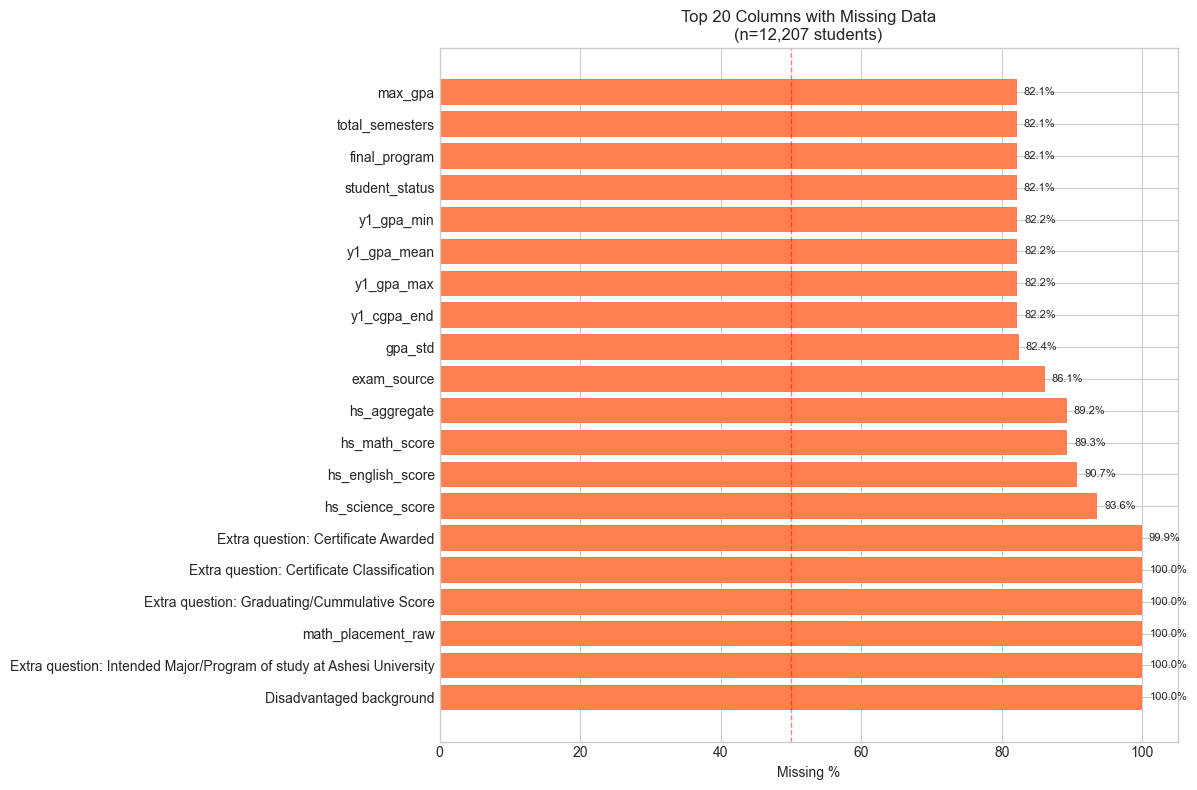

In [26]:
# Missing data in master table
print("="*60)
print("Missing Data Analysis (Master Student Table)")
print("="*60)

missing = master.isnull().sum()
missing_pct = (missing / len(master) * 100).round(1)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)

if len(missing_df) > 0:
    print(f"Columns with missing data: {len(missing_df)}")

    # Plot top 20 with most missing
    fig, ax = plt.subplots(figsize=(12, 8))
    top_missing = missing_df.head(20)
    bars = ax.barh(top_missing.index, top_missing['Missing %'], color='coral')
    ax.set_xlabel('Missing %')
    ax.set_title(f'Top 20 Columns with Missing Data\n(n={len(master):,} students)')
    ax.axvline(50, color='red', linestyle='--', linewidth=1, alpha=0.5)
    for bar, val in zip(bars, top_missing['Missing %']):
        ax.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center', fontsize=8)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'missing_data_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No missing data in master table!")

## 11. Correlation Analysis

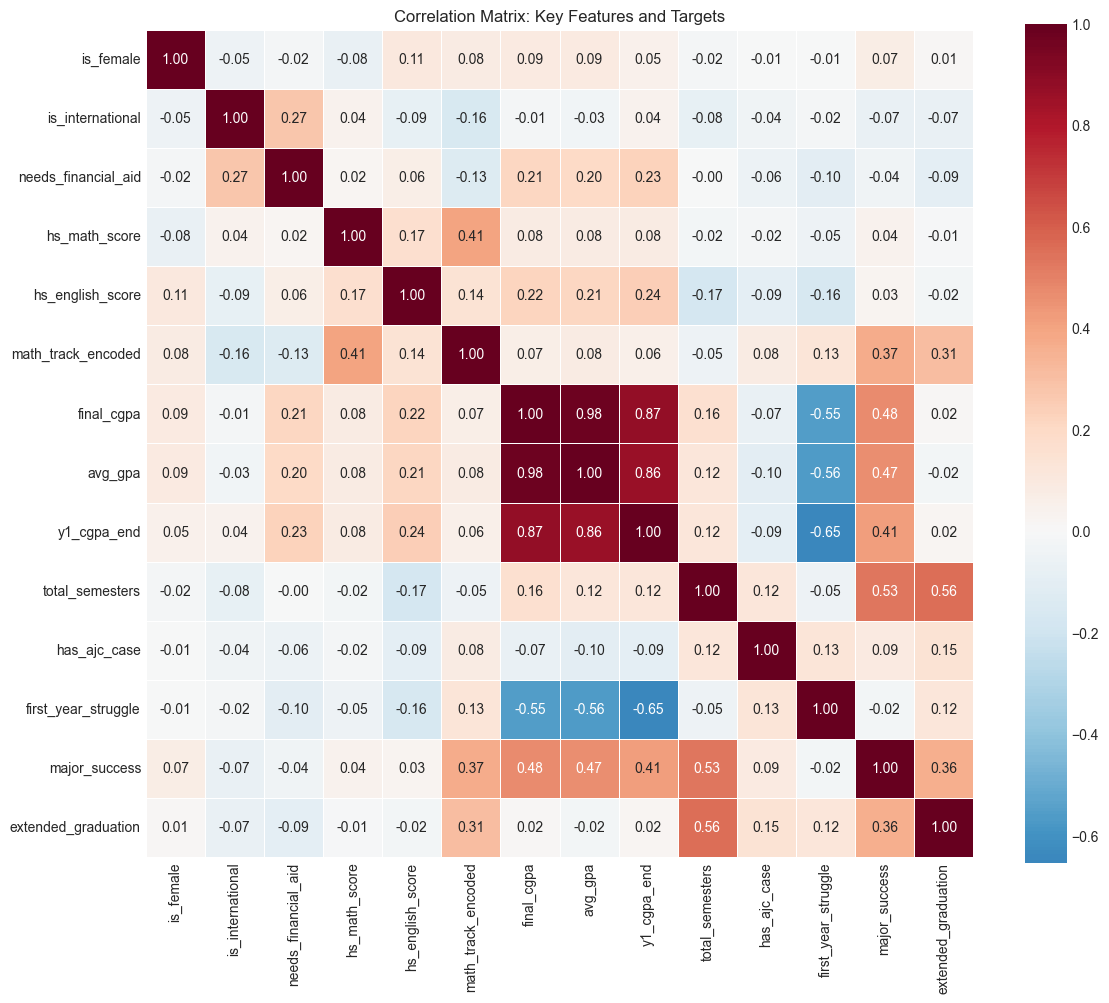

In [27]:
# Correlation analysis for key numeric features
numeric_cols = master.select_dtypes(include=[np.number]).columns.tolist()

# Focus on key features
key_numeric = ['is_female', 'is_international', 'needs_financial_aid',
               'hs_math_score', 'hs_english_score', 'math_track_encoded',
               'final_cgpa', 'avg_gpa', 'y1_cgpa_end', 'total_semesters',
               'has_ajc_case', 'first_year_struggle', 'major_success', 'extended_graduation']
key_numeric = [c for c in key_numeric if c in master.columns]

if len(key_numeric) > 3:
    corr_matrix = master[key_numeric].corr()

    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, ax=ax)
    ax.set_title('Correlation Matrix: Key Features and Targets')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'correlation_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

## 12. Key Findings Summary

In [28]:
print("="*70)
print("EDA KEY FINDINGS SUMMARY")
print("="*70)

# Data summary
print(f"\n📊 DATA OVERVIEW")
print(f"   Total unique students: {len(master):,}")
print(f"   Total features: {len(master.columns)}")

# Demographics
print(f"\n👥 DEMOGRAPHICS")
if 'is_female' in master.columns:
    print(f"   Female students: {master['is_female'].sum():,} ({master['is_female'].mean()*100:.1f}%)")
if 'is_international' in master.columns:
    print(f"   International students: {master['is_international'].sum():,} ({master['is_international'].mean()*100:.1f}%)")

# Math track
print(f"\n📐 MATH TRACK (Using Actual Placement Data)")
if 'math_track' in master.columns:
    for track, count in master['math_track'].value_counts().items():
        print(f"   {track}: {count:,} ({count/len(master)*100:.1f}%)")

# Academic performance
print(f"\n📈 ACADEMIC PERFORMANCE")
if 'final_cgpa' in master.columns:
    valid_cgpa = master['final_cgpa'].dropna()
    print(f"   Average final CGPA: {valid_cgpa.mean():.2f}")
    print(f"   Students below 2.0: {(valid_cgpa < 2.0).sum():,} ({(valid_cgpa < 2.0).mean()*100:.1f}%)")
    print(f"   Students above 3.5: {(valid_cgpa >= 3.5).sum():,} ({(valid_cgpa >= 3.5).mean()*100:.1f}%)")

# Target variables
print(f"\n🎯 TARGET VARIABLES (For Research Questions)")
for col, label in target_cols.items():
    if col in master.columns:
        rate = master[col].mean() * 100
        print(f"   {label}: {rate:.1f}%")

# Recommendations
print(f"\n⚠️ MODELING RECOMMENDATIONS")
print("   1. Use SMOTE or class weights for imbalanced targets (AJC < 5%)")
print("   2. Handle missing high school scores (~30-50% missing)")
print("   3. Consider temporal train-test split to avoid data leakage")
print("   4. Use F2-score to prioritize recall for rare events")

EDA KEY FINDINGS SUMMARY

📊 DATA OVERVIEW
   Total unique students: 12,207
   Total features: 83

👥 DEMOGRAPHICS
   Female students: 4,584 (37.6%)
   International students: 3,915 (32.1%)

📐 MATH TRACK (Using Actual Placement Data)
   Unknown: 10,905 (89.3%)
   Calculus: 1,078 (8.8%)
   Pre-Calculus: 203 (1.7%)
   College Algebra: 21 (0.2%)

📈 ACADEMIC PERFORMANCE
   Average final CGPA: 2.99
   Students below 2.0: 108 (5.0%)
   Students above 3.5: 444 (20.4%)

🎯 TARGET VARIABLES (For Research Questions)
   RQ1: First Year Struggle (Y1 CGPA < 2.0): 1.2%
   RQ2: Has AJC Case: 0.7%
   RQ3-6: Major Success (Graduated CGPA >= 3.0): 5.6%
   RQ9: Extended Graduation (> 8 semesters): 3.2%
   Ever on Probation: 2.2%
   Graduated: 8.8%

⚠️ MODELING RECOMMENDATIONS
   1. Use SMOTE or class weights for imbalanced targets (AJC < 5%)
   2. Handle missing high school scores (~30-50% missing)
   3. Consider temporal train-test split to avoid data leakage
   4. Use F2-score to prioritize recall for rar

In [29]:
# Save master data for next notebooks
print("\n" + "="*60)
print("Saving Processed Data")
print("="*60)
loader.save_processed_data()

print("\n" + "="*60)
print(" EDA COMPLETE ")
print("="*60)
print(f"\nFigures saved to: {RESULTS_DIR}")
print(f"\nNext notebook: 03_feature_engineering.ipynb")


Saving Processed Data
  Saved master_student_data.csv (12,207 students)
  Saved semester_records.csv (24,648 records)

 EDA COMPLETE 

Figures saved to: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude/results/figures

Next notebook: 03_feature_engineering.ipynb
